# CSCE 623 Homework Assignment 3 SOLUTION
Instructor solution inspired by HW3 submission of Lt Joshua Gallaher, CSCE 623, 30 Apr 2019


In [1]:
"""
HW3
"""

import numpy as np
import matplotlib.pyplot as plt
import random

#make plots inline using jupyter magic
%matplotlib inline

import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn import datasets, linear_model

from IPython.display import Markdown as md  #enable markdown within code cell
from IPython.display import display, Math, Latex

#------ADDITIONAL STUDENT IMPORTS----------------
#put student imports below this line

import statistics as st

## STEP 0 (helper functions):
Instructor provided code for data generation & polynomial feature generation


 CHECKING MAKEDATA (Quantity = 5)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       5 non-null      float64
 1   y       5 non-null      float64
dtypes: float64(2)
memory usage: 208.0 bytes


          x          y
0 -0.331912  -2.764113
1  0.881298  -3.981105
2 -1.999543 -14.722820
3 -0.790670   0.229704
4 -1.412976  -7.440010

 CHECKING POLY DESIGN MATRIX
[[ 1.         -0.33191198  0.11016556 -0.03656527]
 [ 1.          0.88129797  0.77668612  0.6844919 ]
 [ 1.         -1.9995425   3.99817021 -7.99451126]
 [ 1.         -0.79066971  0.62515859 -0.49429396]
 [ 1.         -1.41297644  1.99650241 -2.82101086]]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  app.launch_new_instance()


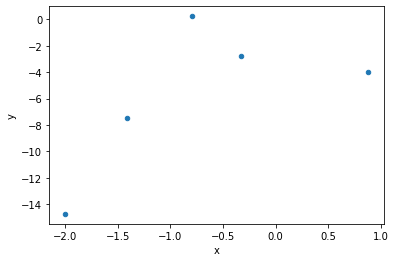

In [2]:
#STEP 0 -  instructor provided

def makeData(myseed=1, quantity = 100):
    np.random.seed(myseed)
    x = np.random.uniform(low=-2.,high=2.,size=quantity)  
    y = x - 2 * (x ** 2) + np.random.normal(size=quantity, scale = 2.0)
    df = pd.DataFrame({'x': x, 'y': y})
    return(df) 


def polyDesignMatrix(x, p):
    '''returns a polynomial design (numpy) matrix from a single feature column vector x.
    The return matrix contains columns of x**0, x**1, … x**p 
    where p is the desired highest order of the polynomial.'''
    x = np.array(x)  
    X = np.transpose(np.vstack((x**k for k in range(p+1))))
    return(X)


#test the function
print("\n CHECKING MAKEDATA (Quantity = 5)")
checkdata = makeData(quantity = 5)
print("\n")
checkdata.info()
checkdata.head()
print("\n")
print(checkdata)
checkdata.plot.scatter(x='x', y='y')
print("\n CHECKING POLY DESIGN MATRIX")
checkpoly = polyDesignMatrix(checkdata['x'],3)
print(checkpoly)



## STEP 1 (data generation and description):

In [3]:
df1=makeData()

# Code to display the answers to question 1 in this cell and/or a markdown cell below
df1.describe()

,x,y
count,100.000000,100.000000
mean,-0.056488,-2.668644
std,1.183539,3.114400
min,-1.999543,-13.030756
25%,-1.160663,-4.956563
50%,-0.117029,-2.332821
75%,0.886971,-0.269798
max,1.955444,3.743904


In [4]:
# Print out df1
df1


,x,y
0,-0.331912,0.079027
1,0.881298,-4.716477
2,-1.999543,-10.608291
3,-0.790670,-0.385038
4,-1.412976,-4.945792
...,...,...
95,-1.051892,-7.057568
96,1.613518,-4.887196
97,0.294718,1.923974
98,-1.988519,-4.840280


In [5]:
# Print out info about df1
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       100 non-null    float64
 1   y       100 non-null    float64
dtypes: float64(2)
memory usage: 1.7 KB


In [6]:
obscount = df1.shape[0]
featurecount = df1.shape[1]-1  #note that the second column is y.  it is not a feature
print("observation count: ", obscount)
print("feature count: ", featurecount)

observation count:  100
feature count:  1


### Step 1  text answer below
how many observations and how many features

There are  100 total observations.

There is 1 feature, "x."
there is one output variable: "y"



## STEP 2 (scatterplot and description):

Text(0.5, 1.0, 'X vs. Y for df1')

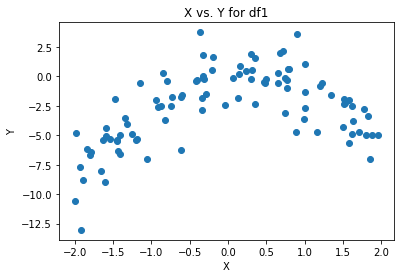

In [7]:
# Scatterplot of x vs y

plt.scatter(df1.x, df1.y)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("X vs. Y for df1")

### Step 2 text answer below

The shape of the data appears to be a parabola that is concave down. As x increases, y initially increases until an inflection point around x = 0.25. After this point, y decreases in value. The relationship appears to be non-linear and polynomial. It appears to be quadratic in nature.

### Official Hypothesis
A model containing quadratic terms will best fit this data. 

## STEP 3 (Ordinary least squares):

In [8]:
def getOLScoefficients(X, y):
    '''computes and returns the OLS coefficients (betas) from design matrix X
    and response variable y.  Returns a ROW VECTOR of betas
    First column of design matrix should contain only values equalling 1.'''
   
    XT = X.T

    # Equation found on https://en.wikipedia.org/wiki/Regression_analysis
    betas = np.dot( np.linalg.inv( np.dot( XT, X ) ), np.dot( XT, y ) )  
    
    return betas

def getOLSpredictions(X, betas):
    '''computes and returns the OLS predictions (yhat) from design matrix X
    and ROW VECTOR betas.  yhat will be a column vector.
    First column of design matrix should contain only values equalling 1.'''
    
    #     Convert from row to column vector
    yhat = np.array( [ np.dot(X, betas) ] ).T


    return(yhat)


## STEP 4 (implement LOOCV as a function):
Define a function to run LOOCV to return cross-validation performance on an OLS regression model with polynomial terms. The signature of a call to this function is LOOCVerr(df, modelOrder), where the dataset is df and the maximum term order is defined by modelOrder.   This function should return a vector of n cross validation error values (squared error terms) that result from n repetitions of training the model on all but the ith observation and predicting on the ith observation. 

For example, if modelOrder = 3, then your function will first obtain a design matrix X produced by polyDesignMatrix on the data feature x (n rows by 4 columns), and then run LOOCV on an OLS regression model for $y=\beta_0+\beta_1x+\beta_2x^2+\beta_3x^3$ using the X & Y data from df.  Since df contains n observations then LOOCVerr will return a vector of length n containing the n individual squared error terms (actual y minus predicted y)2  .
The goal of this step is for you to write code which manages the cross validation.  Call the functions to fit OLS coefficients and make predictions you wrote earlier from within LOOCVerr, and write your own LOOCV cross-validation code to produce your results.  


In [9]:
def LOOCVerr(df, modelOrder):
    
    errorVec = np.zeros((1,df.shape[0]))
    
    # Train the model on all but the ith observation
    for i in range(len(df)):
        # One left out is the ith iteration
        oneLeftOut = df.loc[i]

        # Get rid of the one left out by dropping it
        train_set = df.drop( [i] )

        # Obtain design matrix for X_train
        X_train = polyDesignMatrix( train_set['x'], modelOrder)
        
        # Get the OLS coefficients using the training set
        betas = getOLScoefficients( X_train, train_set['y'])
        
        # Obtain design matrix for one left out
        X_test = polyDesignMatrix( oneLeftOut['x'], modelOrder)
        
        # Get the predictions using the valiation set
        yhat = getOLSpredictions( X_test, betas)

        #Actual y minus predicted y of the validation set
        ydiff = oneLeftOut['y'] - yhat

        yDiffSquared = ydiff ** 2
        
        #errorVec.append( yDiffSquared[0][0] )
        errorVec[0,i]=( yDiffSquared[0][0] )
    
    return errorVec 


## STEP 5 (compute LOOCV errors on polynomial model orders 1,2,3,4):

Using ```df1``` (where you ran makeData with a default seed value of 1) build a for-loop to run LOOCV to generate error vectors using modelOrder values from 1 through 4.  LOOCV will build and return squared error vectors for 4 separate models which were evaluated with linear, linear+quadratic, linear+quadratic+cubic, and linear+quadratic+cubic+quartic terms.  

In [11]:
maxorder = 7

orders = np.arange(1,maxorder+1)

loocv_errs=np.zeros((maxorder,obscount))

for curr_order in orders:  #iterate over possible orders
    resids = LOOCVerr( df1, curr_order)  # temp vector of the residuals from LOOCV prediction
    loocv_errs[curr_order-1,:] = resids  # copy resids into the array




C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  app.launch_new_instance()


## STEP 6 (plot LOOCV MSE as a function of model order ):

Compute the MSEs from the error vectors and plot the MSE results from your LOOCV on models of order 1 through 4.  This plot should have the model order on the x axis and mean squared error on the y axis (MSE is the mean of the squared values of the error terms on the y axis).  Determine the model order with the minimum cross-validation MSE and indicate the minimizing model order on the plot & report it, along with the MSE for that model.  Indicate whether or not the best order model matched your hypothesis in Step 2 and explain any differences. 

MSE values per model order:  [8.51560441 3.36664617 3.45474469 3.54537989 3.62429676 3.72124551
 3.82594539]
Minimum MSE occurs at model order =  2  where MSE =  3.3666461743067755


Text(2, 4.376640026598809, 'Minimum MSE')

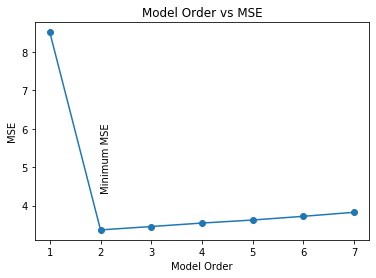

In [12]:


# Find the MSE for each error vector
loocv_mse = np.mean(loocv_errs,axis=1)
print("MSE values per model order: ",loocv_mse)

    
# Make the plot
plt.plot( orders, loocv_mse, marker='o')
plt.xlabel("Model Order")
plt.ylabel("MSE")
plt.title("Model Order vs MSE")
plt.xticks(ticks = orders)

minimum_MSE_model_order = np.argmin(loocv_mse)+1   #find the index of the minimizer and convert to order number
print("Minimum MSE occurs at model order = ", minimum_MSE_model_order," where MSE = ", loocv_mse[minimum_MSE_model_order - 1])
plt.text( minimum_MSE_model_order, 1.3 * min(loocv_mse), "Minimum MSE", rotation=90)  #add a text annotation


### Step 6  text answer below

The best fitting model and MSE for this model is shown in the code output and graph above.  It is the lowest MSE for the models investigated. This matches the hypothesis for the best-fitting model.  While higher order models containing a quadratic term also fit the data fairly well, the terms with higher orders are starting to fit to noise, resulting in worse MSE performance in LOOCV

## STEP 7 (implement valset as a function):

In [13]:
def VALSETerr(df,modelOrder,splitseed): 
   
    # Handle even and odd numbers of data
    # Even just takes half, odd is going to be the majority for the training set
    if ( len(df.index) % 2 == 0 ):
        half = int( len(df.index) / 2 )
    else:
        half = int( ( len(df.index) + 1 ) / 2  )
    
    # Take the sets by sampling and using a random seed
    train_data = df.sample( n=half, random_state=splitseed)
    val_data = pd.concat([ df, train_data ]).drop_duplicates(keep=False)

    # Make design matrix for training data
    X = polyDesignMatrix( train_data['x'], modelOrder)
    
    # Get the betas using the training set
    betas = getOLScoefficients( X, train_data['y'] )
    
    # Get the design matrix for the validation set
    X_val = polyDesignMatrix( val_data['x'], modelOrder )
    
    # Get y preds using the validation set
    yhat = getOLSpredictions( X_val, betas )

    # Convert y data into a column vector
    y = np.array([np.array(val_data['y'].values)]).T
    
    # Actual y minus predicted y of the validation set
    ydiff = y - yhat

    # Find the RSS
    yDiffT = ydiff.T
    rss = np.dot( yDiffT, ydiff)
    
    # Find the MSE
    curr_MSE = rss / len(val_data.index)
    #mse.append( curr_MSE[0][0] )

    #return mse[0]
    return curr_MSE


## STEP 8 (implement k-fold cross-validation as a function):

In [14]:
def KFOLDerr(df,modelOrder,k,splitseed):
    errorterms = np.zeros((k))
    
    # Shuffle the data
    df_shuffled = df.sample(frac=1, random_state=splitseed).reset_index(drop=True)
    
    
    # For each validation fold possible:
    for fold in range( k ):
        
        # Create fresh train and val sets
        train_set = df_shuffled
        val_set = df_shuffled
            
        # If the row is a mod of the k-folds, then drop from train_set
        # Otherwise, drop from val_set 
        for row in range( len( df ) ):

            if ( row % k  == fold ):
                train_set = train_set.drop( [ row ] )
            else:
                val_set = val_set.drop( [ row ] )
                
        # Make design matrix for training data
        X = polyDesignMatrix( train_set['x'], modelOrder)

        # Get the betas using the training set
        betas = getOLScoefficients( X, train_set['y'] )

        # Get the design matrix for the validation set
        X_val = polyDesignMatrix( val_set['x'], modelOrder )

        # Get y preds using the validation set
        yhat = getOLSpredictions( X_val, betas )

        # Convert y data into a column vector
        y = np.array([np.array(val_set['y'].values)]).T

        # Actual y minus predicted y of the validation set
        ydiff = y - yhat

        # Find the RSS
        yDiffT = ydiff.T
        rss = np.dot( yDiffT, ydiff)

        # Find the MSE
        MSE = rss / len(val_set.index)
    
        errorterms[fold]=MSE[0][0]
        
    return errorterms


## STEP 9 (compute and collect MSEs from validation methods):

In [ ]:
seed_count = 10
seeds = np.arange(1,seed_count+1) #use seed vals 1...10
val_set_MSEs=np.zeros((maxorder,seed_count))
five_fold_CV_MSEs = np.zeros((maxorder,seed_count))
ten_fold_CV_MSEs = np.zeros((maxorder,seed_count))


for seed_index,seed in enumerate(seeds):
    val_set = []
    five_fold = []
    ten_fold = []
    
    for model_index,model in enumerate(orders):
        val_set_MSEs[model_index,seed_index]=VALSETerr( df1, model, seed ) 
        five_fold_CV_MSEs[model_index,seed_index] = st.mean(KFOLDerr( df1, model, 5, seed ) )
        ten_fold_CV_MSEs[model_index,seed_index] = st.mean( KFOLDerr( df1, model, 10, seed ) ) 

  

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  app.launch_new_instance()


## STEP 10 (build "spaghetti" plots of cross validation results):

In [ ]:
#helper function for subplot
def mysubplot(orders,seeds,mse_array,subplot_title):
    for seed_index,seed in enumerate(seeds):
        labelseed = "Seed " + str(seed)
        min_mse = min(mse_array[:,seed_index]) #find the min value for mse for this seed
        index_min = np.argmin(mse_array[:,seed_index]) #find the index of minimal mse for the order number
        markers_on = [index_min] #marker will only be on for the best point
        plt.plot( orders, mse_array[:,seed_index], marker='o', markevery=markers_on, label=labelseed )
    
    plt.title(subplot_title)
    plt.legend(loc='best')
    plt.xlabel('Model Order')
    plt.ylabel('MSE')
    

fig = plt.figure(figsize=(12,20))
plt.subplots_adjust(hspace=.3) #add some space between subplots to separate titles and axis labels

# For each plot, create a subplot and plot the data
plt.subplot(3, 1, 1)
mysubplot(orders,seeds,val_set_MSEs,"Validation Set")

plt.subplot(3, 1, 2)
mysubplot(orders,seeds,five_fold_CV_MSEs,"5-fold CV")

plt.subplot(3, 1, 3)
mysubplot(orders,seeds,ten_fold_CV_MSEs,"10-fold CV")




## STEP 11 (human estimate of most reliable validation technique):

Text(0.5, 1.0, 'Variance in MSE estimates for Validaiton Methods')

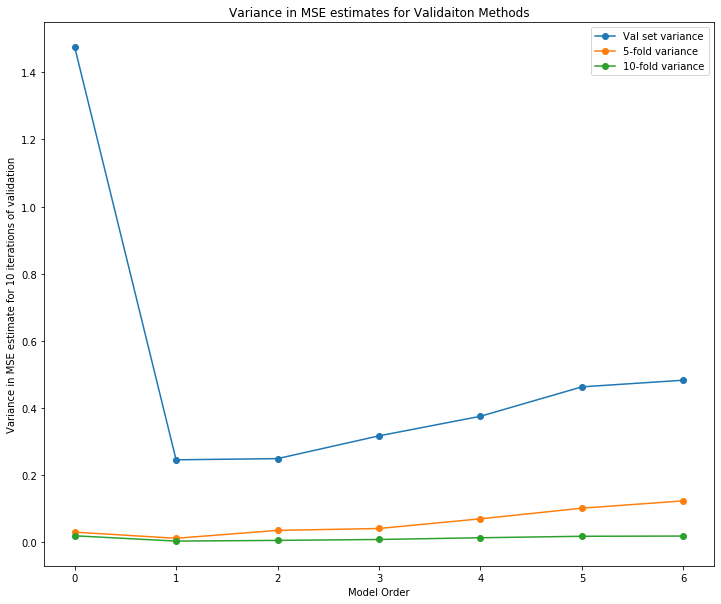

In [16]:
#optional additional code for reliablity determination using variance - 

#take variance across the seeds for each val method
val_set_var = np.var(val_set_MSEs,axis=1)
five_fold_var = np.var(five_fold_CV_MSEs,axis=1)
ten_fold_var = np.var(ten_fold_CV_MSEs,axis=1)

#plot lines for each model variance
fig = plt.figure(figsize=(12,10))
plt.plot( val_set_var,  marker='o',label="Val set variance" )
plt.plot( five_fold_var,  marker='o',label = "5-fold variance" )
plt.plot( ten_fold_var,  marker='o',label = "10-fold variance" )
plt.legend(loc='best')
plt.xlabel('Model Order')
plt.ylabel('Variance in MSE estimate for 10 iterations of validation')
plt.title('Variance in MSE estimates for Validaiton Methods')



### Step 11 text answer below
We can use variance in the estimate as a measure of reliability; the lower the variance of the MSEs computed from the different seeds, the more reliable our decision of which order is best should be.  Using this as our reliability criteria, the most reliable validation technique is K-fold (10-fold cross validation is the most reliable for all orders). This validation technique has low variability on estimated error rate for unseen observations. Of these three validation methods, Ten-fold cross validation technique probably performs slightly better because it uses more data for training (9/10 of the data) and has less chance for a statistical sample bias. 

## STEP 12 (algorithmic determination of best-order model from most reliable val method) :

best orders per seed: [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
cumulative counts of best orders:  [ 0. 10.  0.  0.  0.  0.  0.]
The best order is model: 2


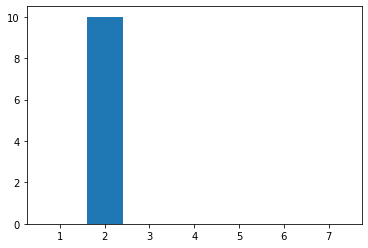

In [17]:

# To determine the best-order model, we are simply going to take whichever model has the 
# majority of the minimum points from each seed

model_best_counts = np.zeros(orders.shape)
seed_best_orders = np.zeros(seeds.shape)

for seed_index,seed in enumerate(seeds):
    # Find the min MSE in each set
    min_mse = min(ten_fold_CV_MSEs[:,seed_index])
    index_min = np.argmin(ten_fold_CV_MSEs[:,seed_index]) 
    seed_best_orders[seed_index] = index_min+1

    model_best_counts[index_min]+=1
    

print("best orders per seed:", seed_best_orders)
print("cumulative counts of best orders: ", model_best_counts)

best_order = np.argmax(model_best_counts)+1
binctrs = np.arange(1,maxorder+1)

#plt.hist(seed_best_orders,bins=binctrs,align="left")
plt.bar(binctrs,model_best_counts)

print( "The best order is model: " + str( best_order ))


### Step 12 text answer below

All 10 of the 10-fold CrossValidation results yielded the same answer for the best model.  The best order is model 2. This result matches the hypothesis.